In [62]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 500
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import FancyArrowPatch
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [63]:
# FITS File 
image = 'Test/SIE/SIE_POS_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie = hdu_list[0].data[4]
gamma1_sie = np.array(gamma1_sie)

gamma2_sie = hdu_list[0].data[5]
gamma2_sie = np.array(gamma2_sie)

Filename: Test/SIE/SIE_POS_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [64]:
# FITS File 
image = 'Test/SIE+SHEAR/SIE_POS_SHEAR_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie_shear = hdu_list[0].data[4]
gamma1_sie_shear = np.array(gamma1_sie_shear)

gamma2_sie_shear = hdu_list[0].data[5]
gamma2_sie_shear = np.array(gamma2_sie_shear)

Filename: Test/SIE+SHEAR/SIE_POS_SHEAR_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [65]:
# FITS File 
image = 'Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie_fix = hdu_list[0].data[4]
gamma1_sie_fix = np.array(gamma1_sie_fix)

gamma2_sie_fix = hdu_list[0].data[5]
gamma2_sie_fix = np.array(gamma2_sie_fix)

Filename: Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [66]:
gamma_sie = np.sqrt(gamma1_sie**2 + gamma2_sie**2)
gamma_sie_shear = np.sqrt(gamma1_sie_shear**2 + gamma2_sie_shear**2)
gamma_sie_fix = np.sqrt(gamma1_sie_fix**2 + gamma2_sie_fix**2)

In [67]:
obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1)
obs_point[0] = (obs_point[0] - 20) / 0.001
obs_point[1] = (obs_point[1] - 20) / 0.001
obs_point = obs_point[[0, 1]]
obs_point

,0,1
0,777.73,302.54
1,1273.08,956.12
2,390.91,1050.57
3,819.81,1259.31


In [68]:
file_crit = 'Test/SIE/SIE_POS_crit.dat'
print(file_crit)
crit_curve_sie = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve_sie = (crit_curve_sie - 20) / 0.001
crit_curve_sie

Test/SIE/SIE_POS_crit.dat


,0,1,2,3,4,5,6,7
0,788.5,434.0,789.36,761.71,788.0,434.5,789.34,762.23
1,788.5,434.0,789.36,761.71,789.5,434.0,789.36,761.69
2,789.5,434.0,789.36,761.69,790.5,434.0,789.36,761.66
3,790.5,434.0,789.36,761.66,791.5,434.0,789.36,761.63
4,791.5,434.0,789.36,761.63,792.5,434.0,789.37,761.59
...,...,...,...,...,...,...,...,...
2749,780.0,780.0,463.75,881.84,780.0,780.0,456.66,860.03
2750,780.0,780.0,456.66,860.03,780.0,780.0,451.16,837.95
2751,780.0,780.0,451.16,837.95,780.0,780.0,447.23,815.70
2752,780.0,780.0,447.23,815.70,780.0,780.0,444.89,793.38


In [69]:
file_crit = 'Test/SIE+SHEAR/SIE_POS_SHEAR_crit.dat'
print(file_crit)
crit_curve_sie_shear = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve_sie_shear = (crit_curve_sie_shear - 20) / 0.001
crit_curve_sie_shear

Test/SIE+SHEAR/SIE_POS_SHEAR_crit.dat


,0,1,2,3,4,5,6,7
0,859.5,460.0,791.87,873.52,859.0,460.5,791.70,873.97
1,859.5,460.0,791.87,873.52,860.5,460.0,791.97,873.27
2,860.5,460.0,791.97,873.27,861.5,460.0,792.08,873.02
3,861.5,460.0,792.08,873.02,862.5,460.0,792.18,872.77
4,862.5,460.0,792.18,872.77,863.5,460.0,792.29,872.51
...,...,...,...,...,...,...,...,...
3193,780.0,780.0,462.80,881.89,780.0,780.0,455.71,860.07
3194,780.0,780.0,455.71,860.07,780.0,780.0,450.21,837.98
3195,780.0,780.0,450.21,837.98,780.0,780.0,446.28,815.72
3196,780.0,780.0,446.28,815.72,780.0,780.0,443.94,793.39


In [70]:
file_crit = 'Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_crit.dat'
print(file_crit)
crit_curve_sie_fix = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve_sie_fix = (crit_curve_sie_fix - 20) / 0.001
crit_curve_sie_fix

Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_crit.dat


,0,1,2,3,4,5,6,7
0,843.5,488.0,789.65,866.26,843.0,488.5,789.48,866.75
1,843.5,488.0,789.65,866.26,844.5,488.0,789.73,866.01
2,844.5,488.0,789.73,866.01,845.5,488.0,789.81,865.76
3,845.5,488.0,789.81,865.76,846.5,488.0,789.90,865.51
4,846.5,488.0,789.90,865.51,847.5,488.0,789.99,865.26
...,...,...,...,...,...,...,...,...
2853,780.0,780.0,461.84,881.87,780.0,780.0,454.76,860.06
2854,780.0,780.0,454.76,860.06,780.0,780.0,449.25,837.97
2855,780.0,780.0,449.25,837.97,780.0,780.0,445.33,815.72
2856,780.0,780.0,445.33,815.72,780.0,780.0,442.99,793.39


In [71]:
pred_point = pd.read_csv('Test/SIE/SIE_POS_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / 0.001
pred_point[1] = (pred_point[1] - 20) / 0.001
pred_point_sie = pred_point[[0, 1]]
pred_point_sie

,0,1
0,909.3,481.0
1,469.5,645.7
2,1090.5,914.3
3,650.7,1079.0


In [72]:
pred_point = pd.read_csv('Test/SIE+SHEAR/SIE_POS_SHEAR_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / 0.001
pred_point[1] = (pred_point[1] - 20) / 0.001
pred_point_shear = pred_point[[0, 1]]
pred_point_shear

,0,1
0,757.2,312.3
1,1085.7,754.1
2,476.1,805.4
3,808.3,1247.4


In [73]:
pred_point = pd.read_csv('Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / 0.001
pred_point[1] = (pred_point[1] - 20) / 0.001
pred_point_fix = pred_point[[0, 1]]
pred_point_fix

,0,1
0,759.6,370.8
1,1060.8,753.5
2,502.5,805.5
3,811.4,1188.5


In [74]:
# Row Switching

dist_matrix = cdist(obs_point.to_numpy(), pred_point_sie.to_numpy(), 'euclidean')
obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)
pred_point_sie_sort = pred_point_sie.iloc[pred_indices_optimal].reset_index(drop=True)

dist_matrix = cdist(obs_point.to_numpy(), pred_point_shear.to_numpy(), 'euclidean')
obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)
pred_point_shear_sort = pred_point_shear.iloc[pred_indices_optimal].reset_index(drop=True)

dist_matrix = cdist(obs_point.to_numpy(), pred_point_fix.to_numpy(), 'euclidean')
obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)
pred_point_fix_sort = pred_point_fix.iloc[pred_indices_optimal].reset_index(drop=True)

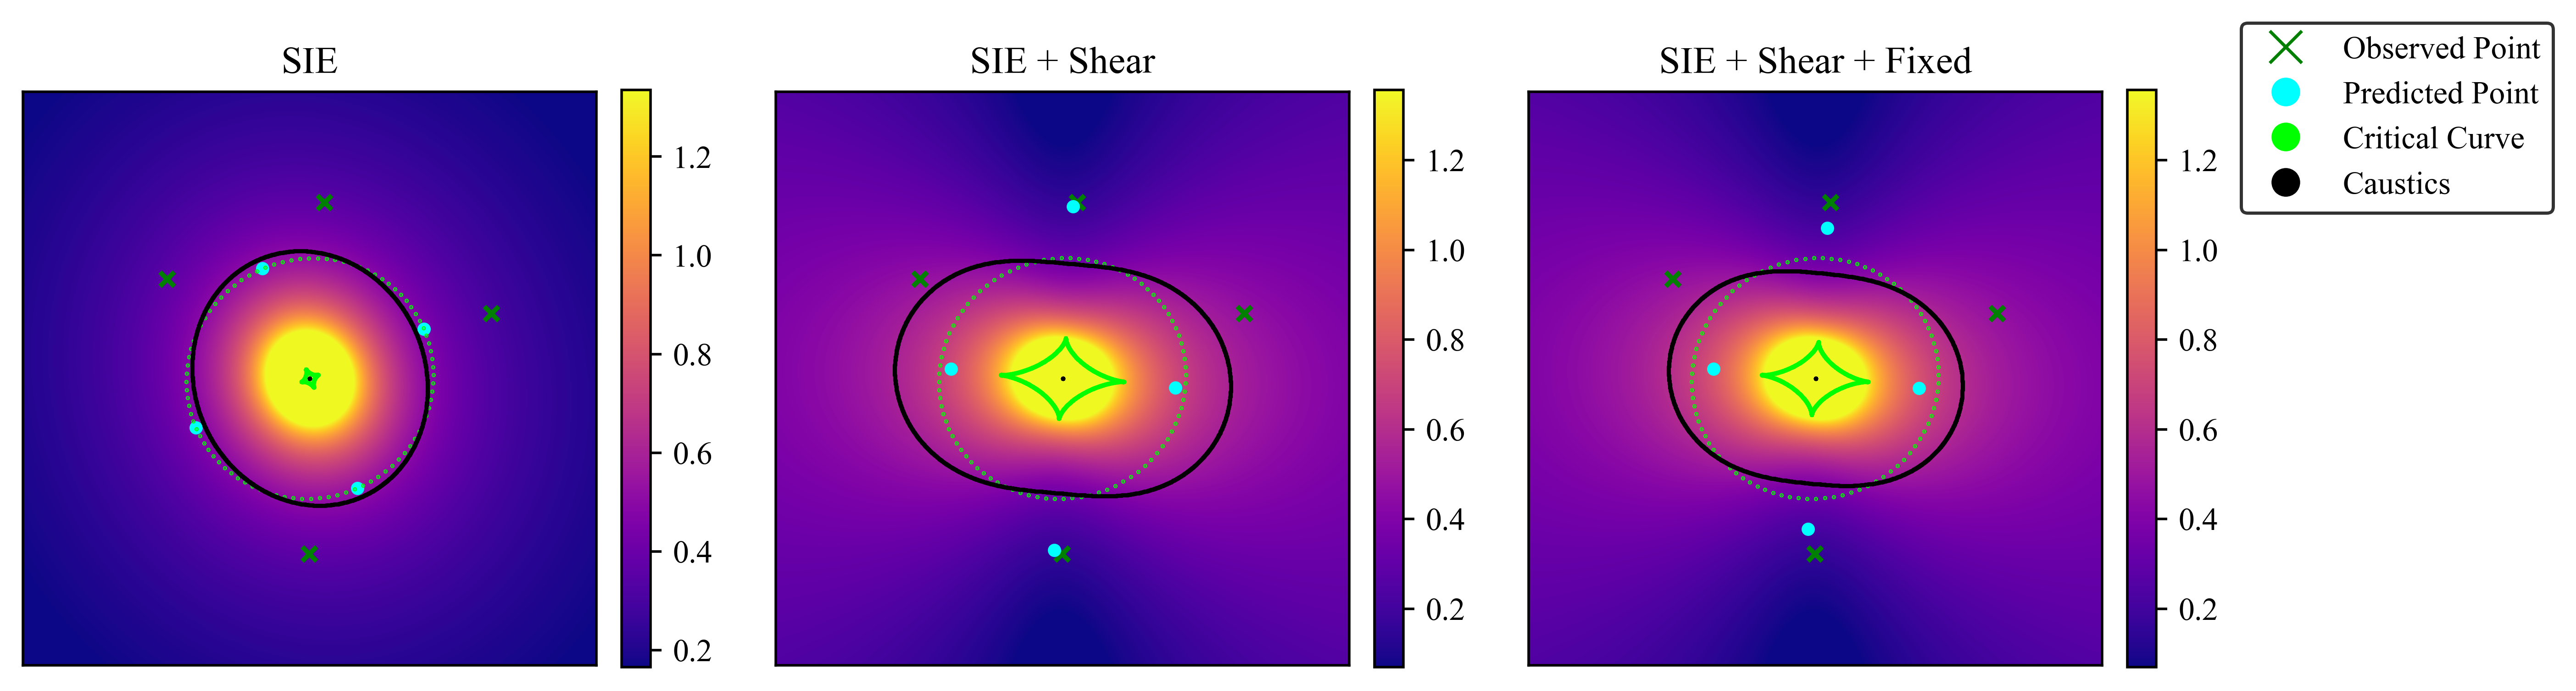

In [89]:
# Plot all 3 figures
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# SIE
vmax, vmin = np.percentile(gamma_sie, [98, 2])

ax = axs[0]
ax.imshow(gamma_sie, origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
ax.scatter(obs_point[0], obs_point[1], color='green', s=20, label='Observed Point', marker='x')
ax.scatter(pred_point_sie_sort[0], pred_point_sie_sort[1], color='cyan', s=10, label='Predicted Point')
ax.scatter(crit_curve_sie[2], crit_curve_sie[3], color='lime', label='Critical Curve', s=0.1)
ax.scatter(crit_curve_sie[4], crit_curve_sie[5], color='k', label='Caustics', s=0.1)
ax.set_title('SIE')
ax.set_xticks([])
ax.set_yticks([])
ax.colourbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)


# SIE + Shear
vmax, vmin = np.percentile(gamma_sie_shear, [98, 2])

ax = axs[1]
ax.imshow(gamma_sie_shear, origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
ax.scatter(obs_point[0], obs_point[1], color='green', s=20, label='Observed Point', marker='x')
ax.scatter(pred_point_shear_sort[0], pred_point_shear_sort[1], color='cyan', s=10, label='Predicted Point')
ax.scatter(crit_curve_sie_shear[2], crit_curve_sie_shear[3], color='lime', label='Critical Curve', s=0.1)
ax.scatter(crit_curve_sie_shear[4], crit_curve_sie_shear[5], color='k', label='Caustics', s=0.1)
ax.set_title('SIE + Shear')
ax.set_xticks([])
ax.set_yticks([])
ax.colourbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

# SIE + Shear + Fixed
vmax, vmin = np.percentile(gamma_sie_fix, [98, 2])

ax = axs[2]
ax.imshow(gamma_sie_fix, origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
ax.scatter(obs_point[0], obs_point[1], color='green', s=20, label='Observed Point', marker='x')
ax.scatter(pred_point_fix_sort[0], pred_point_fix_sort[1], color='cyan', s=10, label='Predicted Point')
ax.scatter(crit_curve_sie_fix[2], crit_curve_sie_fix[3], color='lime', label='Critical Curve', s=0.1)
ax.scatter(crit_curve_sie_fix[4], crit_curve_sie_fix[5], color='k', label='Caustics', s=0.1)
ax.set_title('SIE + Shear + Fixed')
ax.set_xticks([])
ax.set_yticks([])
ax.colourbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

legend_elements = [
    Line2D([0], [0], marker='x', color='w', markerfacecolor='green', markeredgecolor='green', markersize=5, label='Observed Point'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=5, label='Predicted Point'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=5, label='Critical Curve'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5, label='Caustics')
]

fig.legend(handles=legend_elements, loc='upper right', fontsize = 'medium', bbox_to_anchor=(1.05, 0.9), markerscale=2, frameon=True, facecolor='white', framealpha=0.8, edgecolor='black')
plt.show()